In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from luminol.anomaly_detector import AnomalyDetector

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_feather("measurement_data/traceroute_1.feather")
df

,index,created,probe_id,source_address,end_time,paris_id,total_hops,last_median_rtt,destination_ip_responded,last_hop_responded,is_success,last_hop_errors,total_hops_average_diff
0,0,2021-11-25 16:14:49+00:00,6025,213.225.160.239,2021-11-25 16:14:55+00:00,15,9,155.201,True,True,True,[],0.0
1,1,2021-11-25 16:14:59+00:00,6030,193.105.163.172,2021-11-25 16:15:06+00:00,15,12,161.019,True,True,True,[],0.0
2,2,2021-11-25 16:14:59+00:00,6031,145.220.0.55,2021-11-25 16:15:25+00:00,15,9,152.612,True,True,True,[],0.0
3,3,2021-11-25 16:14:53+00:00,6041,213.190.96.41,2021-11-25 16:15:26+00:00,15,7,192.820,True,True,True,[],0.0
4,4,2021-11-25 16:14:58+00:00,6043,192.65.184.54,2021-11-25 16:15:13+00:00,15,9,194.379,True,True,True,[],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345843,345843,2021-11-30 15:00:02+00:00,7030,45.11.104.146,2021-11-30 15:00:17+00:00,10,12,152.791,True,True,True,[],0.0
345844,345844,2021-11-30 15:00:01+00:00,7033,85.93.215.82,2021-11-30 15:00:04+00:00,10,11,145.836,True,True,True,[],0.0
345845,345845,2021-11-30 15:00:04+00:00,7039,103.170.232.152,2021-11-30 15:00:30+00:00,10,9,108.516,True,True,True,[],0.0
345846,345846,2021-11-30 15:00:00+00:00,7045,5.188.202.25,2021-11-30 15:00:00+00:00,10,1,0.091,True,True,True,[],0.0


In [4]:
# Add row with difference to median for rtt_min
median_dict = {}
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median_dict[i] = single_probe["rtt_min"].median()

def find_difference(probe_id, rtt_average):
    return rtt_average - median_dict[probe_id]

df["rtt_min_diff"] = np.vectorize(find_difference)(df['probe_id'], df['rtt_min'])

In [5]:
# Add row with difference to median for rtt_average
median_dict = {}
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    median_dict[i] = single_probe["rtt_average"].median()

def find_difference(probe_id, rtt_average):
    return rtt_average - median_dict[probe_id]

df["rtt_average_diff"] = np.vectorize(find_difference)(df['probe_id'], df['rtt_average'])

In [6]:
df["probe_id"].value_counts()

6278    1336
6792     923
6299     917
6289     915
6276     477
        ... 
6579     368
6527     366
6856     166
6804     105
6749      34
Name: probe_id, Length: 725, dtype: int64

<AxesSubplot:xlabel='created', ylabel='total_hops'>

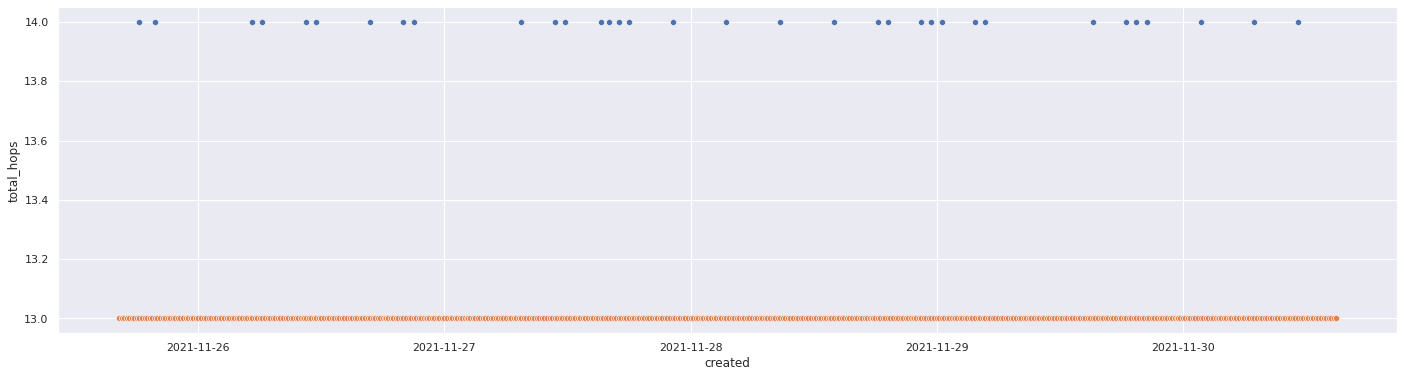

In [12]:
# Compare probe with most datapoints with the least datapoints
sns.set(rc={"figure.figsize":(24, 6)})
sns.scatterplot(data=df[df["probe_id"] == 6749], x="created", y="total_hops")
sns.scatterplot(data=df[df["probe_id"] == 6278], x="created", y="total_hops")

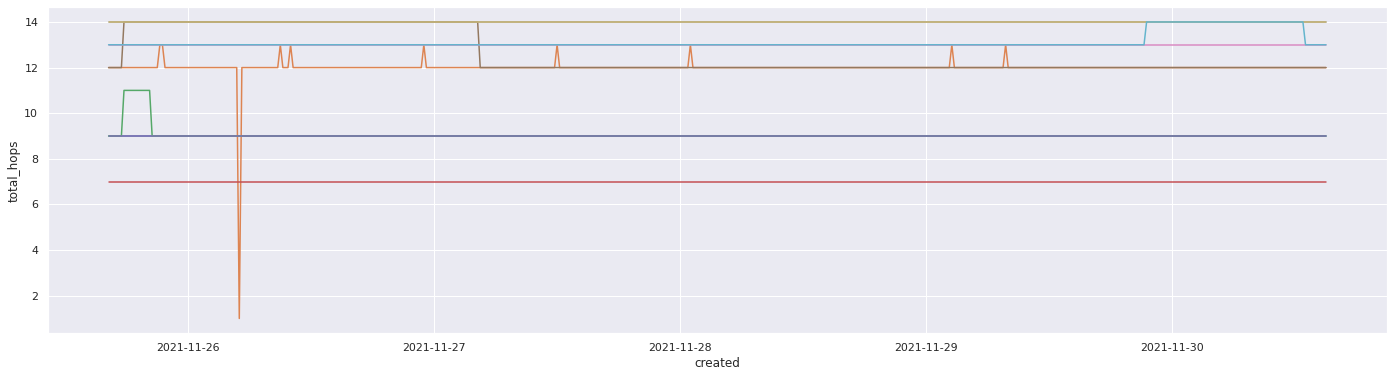

In [27]:
for i in df["probe_id"].unique()[:10]:
    single_probe = df[df["probe_id"] == i]
    sns.lineplot(data=single_probe, x="created", y="total_hops")

In [42]:
for i in df["probe_id"].unique()[:10]:
    single_probe = df[df["probe_id"] == i]
    print(single_probe["total_hops"].std())

0.0
0.5231314550275838
0.3008171092464542
0.0
0.0
0.910336728286708
0.0
0.0
0.0
0.3369346953683242


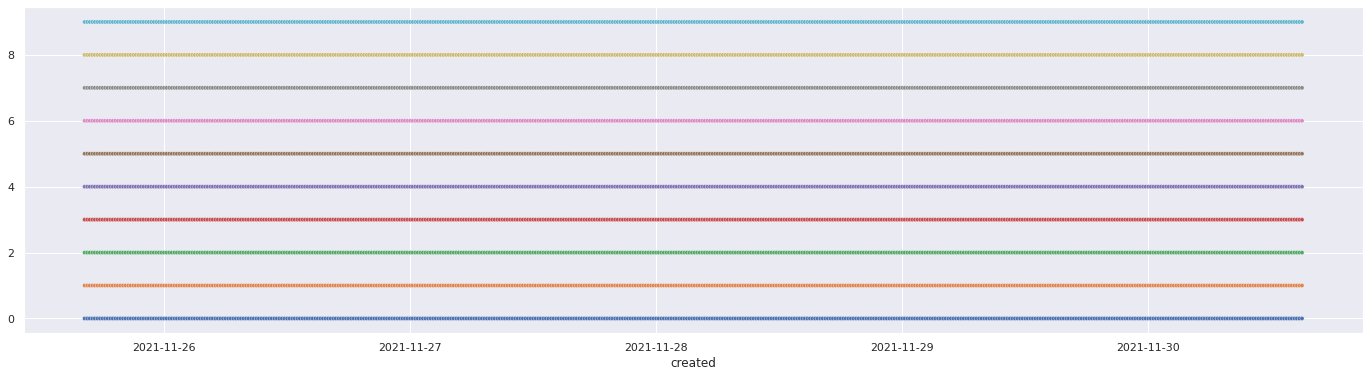

In [39]:
sns.set(rc={"figure.figsize":(24, 6)})

counter = 0

def feature_scaling(minimum, maximum, value):
    if maximum - minimum == 0:
        return 0.
    else:
        return ((value - minimum) / (maximum - minimum))

for i in df["probe_id"].unique()[:10]:
    single_probe = df[df["probe_id"] == i]

    minimum = single_probe["total_hops"].min()
    maximum = single_probe["total_hops"].max()

    single_probe["hop_value"] = single_probe["total_hops"].apply(lambda x: feature_scaling(minimum, maximum, x))

    sns.scatterplot(data=single_probe, x="created", y=counter, size="hop_value", hue="hop_value", palette="dark:#FF0", legend=False)
    counter += 1

Probe ID: 6932
Median RTT: 146.14344 Average RTT: 146.55881528148146
Start date: 2021-06-07 00:02:08+00:00 End date: 2021-06-09 23:58:15+00:00 Measurement time: 2 days 23:56:07
Amount of data points: 1080


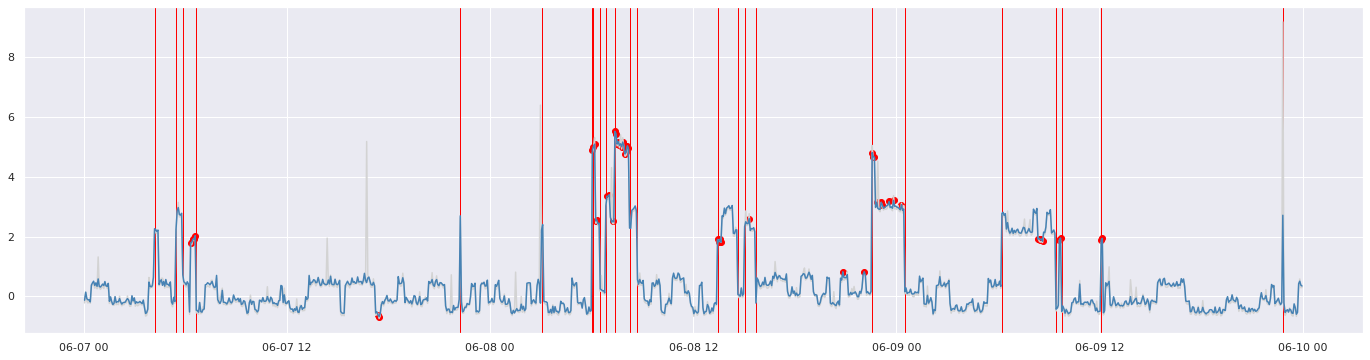

In [19]:
random_probe = df["probe_id"].sample(n=1, random_state=75).unique()[0]
# random_probe = 6229
print(f"Probe ID: {random_probe}")
single_probe1 = df[df["probe_id"] == random_probe]
single_probe1_median = single_probe1["rtt_min"].median()
single_probe1_mean = single_probe1["rtt_min"].mean()

print(f"Median RTT: {single_probe1_median} Average RTT: {single_probe1_mean}")

single_probe1_start = single_probe1["created"].min()
single_probe1_end = single_probe1["created"].max()
single_probe1_length = single_probe1_end - single_probe1_start
print(f"Start date: {single_probe1_start} End date: {single_probe1_end} Measurement time: {single_probe1_length}")

single_probe1_datapoints = len(single_probe1)
print(f"Amount of data points: {single_probe1_datapoints}")

# Outlier detection
clf = IsolationForest(contamination=0.05)
single_probe1["outlier"] = clf.fit_predict(single_probe1[["rtt_min", "duplicates", "dropped_packets"]])

# Anomaly detection
algo_settings = {
      'precision':4, # how many sections to categorize values
      'lag_window_size':2, # lagging window size
      'future_window_size':2, # future window size,
      'chunk_size':4 # chunk size.
    }

ts = single_probe1["rtt_min"].to_dict()
detector = AnomalyDetector(ts, algorithm_name="bitmap_detector", algorithm_params=algo_settings)
anomalies = detector.get_anomalies()

fig, ax = plt.subplots(figsize=(24,6))

for anomaly in anomalies:
    start = single_probe1.at[anomaly.start_timestamp, "created"]
    end = single_probe1.at[anomaly.end_timestamp, "created"]
    score = anomaly.anomaly_score
    ax.axvspan(xmin=start, xmax=end, color="red")

a = single_probe1.loc[single_probe1['outlier'] == -1, ['created', 'rtt_min_diff']]
ax.plot(single_probe1['created'], single_probe1['rtt_average_diff'], color='lightgrey')
ax.plot(single_probe1['created'], single_probe1['rtt_min_diff'], color='steelblue')
# 
ax.scatter(a["created"], a["rtt_min_diff"], color="red")
plt.show()

<AxesSubplot:xlabel='rtt_min_diff', ylabel='Count'>

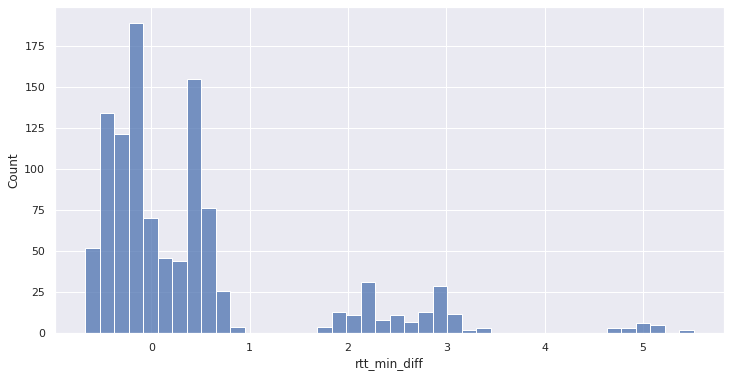

In [7]:
# check for normal distribution
sns.set(rc={"figure.figsize":(12, 6)})
sns.histplot(data=single_probe1, x="rtt_min_diff")

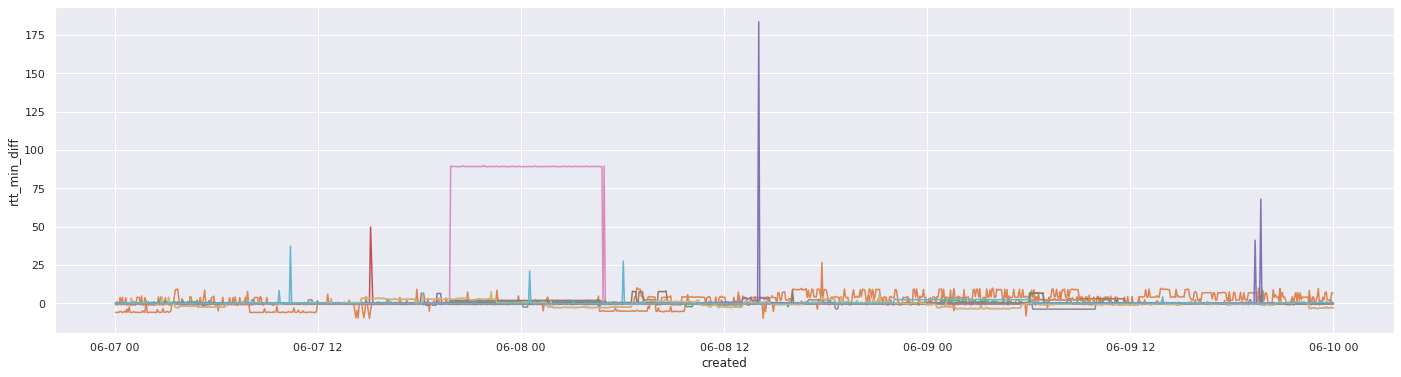

In [8]:
# compare 5 random probes to see if there is overlap in peaks
sns.set(rc={"figure.figsize":(24, 6)})
for i in df["probe_id"].sample(n=20):
    single_probe = df[df["probe_id"] == i]
    sns.lineplot(data=single_probe, x="created", y="rtt_min_diff")

In [49]:
# Find outliers in total dataset
# clf = OneClassSVM(nu=0.005, gamma=.01)
clf = IsolationForest(contamination=0.05)
df_outlier = pd.DataFrame()
for i in df["probe_id"].unique():
    single_probe = df[df["probe_id"] == i]
    
    single_probe["outlier"] = clf.fit_predict(single_probe[["rtt_min", "duplicates", "dropped_packets"]])
    single_probe["outlier_score"] = clf.score_samples(single_probe[["rtt_min", "duplicates", "dropped_packets"]])
    single_probe["outlier"] = single_probe["outlier"].apply(lambda x: 0 if x == 1 else 1)
    single_probe["weight"] = single_probe["rtt_min"].mean()
    df_outlier = df_outlier.append(single_probe)


display(df_outlier)

,index,created,probe_id,duplicates,rtt_average,rtt_max,rtt_min,rtt_median,dropped_packets,rtt_min_diff,rtt_average_diff,outlier,outlier_score,weight
0,0,2021-06-07 00:02:11+00:00,6025,0,149.218,149.233853,149.195256,149.225,0,-0.043513,-0.132,0,-0.390401,149.308156
587,623,2021-06-07 00:06:18+00:00,6025,0,149.493,149.498309,149.487248,149.493,0,0.248479,0.143,0,-0.474803,149.308156
1173,1246,2021-06-07 00:10:17+00:00,6025,0,149.315,149.341522,149.265693,149.337,0,0.026924,-0.035,0,-0.412035,149.308156
1758,1868,2021-06-07 00:14:20+00:00,6025,0,149.209,149.391889,149.037659,149.199,0,-0.201110,-0.141,0,-0.511728,149.308156
2346,2492,2021-06-07 00:18:18+00:00,6025,0,149.551,150.059528,149.242088,149.352,0,0.003319,0.201,0,-0.395332,149.308156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635162,675573,2021-06-09 23:42:14+00:00,7010,0,179.879,179.885990,179.872332,179.878,0,-0.026884,-0.045,0,-0.483439,179.900196
635755,676203,2021-06-09 23:46:22+00:00,7010,0,179.884,179.903939,179.866280,179.880,0,-0.032936,-0.040,0,-0.488940,179.900196
636348,676833,2021-06-09 23:50:16+00:00,7010,0,179.969,180.029638,179.929781,179.949,0,0.030565,0.045,0,-0.453052,179.900196
636941,677463,2021-06-09 23:54:20+00:00,7010,0,179.921,179.961030,179.863718,179.939,0,-0.035498,-0.003,0,-0.539303,179.900196


In [ ]:
# Give higher weights to probes with lower average RTT (closer probes)
df_outlier["weight"] = 0
df

<AxesSubplot:xlabel='created'>

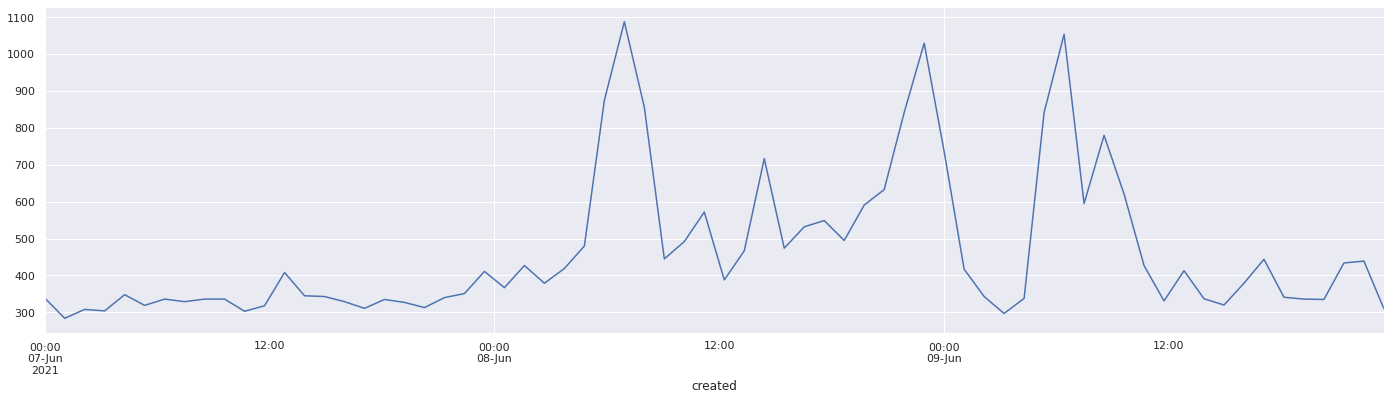

In [46]:
# Create anomaly score frame
df_outlier.groupby(pd.Grouper(key="created", freq="64T"))["outlier"].agg("sum").plot()

<AxesSubplot:xlabel='created'>

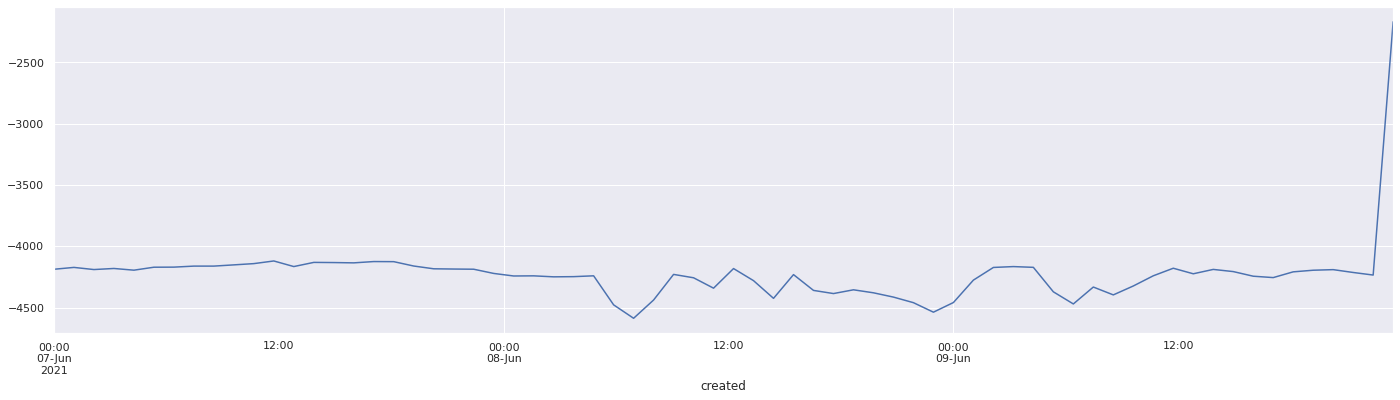

In [47]:
df_outlier.groupby(pd.Grouper(key="created", freq="64T"))["outlier_score"].agg("sum").plot()